# Raster Mosaicing and Clipping

## Overview

This tutorial is based on [Raster Mosaicing and Clipping (QGIS3)](https://www.qgistutorials.com/en/docs/3/raster_mosaicing_and_clipping.html).

We will work with elevation data for Sri Lanka in the form of SRTM tiles, merge them and clip the resulting mosaic to the country boundary. We will also generate a hillshare from the resulting merged dataset.


Input Layers:
* `[NXXEYYY].SRTMGL1.hgt.zip`: Zipped raster tiles in SRTM HGT format
* `ne_10m_admin_0_countries.zip`: A shapefile of country boundaries

Output:
* `hillshade.tif`: A GeoTiff file of hillshade for Sri Lanka

Data Credit: 
- NASA Shuttle Radar Topography Mission Global 1 arc second provided by The Land Processes Distributed Active Archive Center (LP DAAC). Downloaded using 30-Meter SRTM Tile Downloader
- Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.



## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray --quiet
    !pip install earthpy --quiet

In [22]:
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N05E080.SRTMGL1.hgt.zip',
  'N06E079.SRTMGL1.hgt.zip',
  'N06E080.SRTMGL1.hgt.zip',
  'N06E081.SRTMGL1.hgt.zip',
  'N07E079.SRTMGL1.hgt.zip',
  'N07E080.SRTMGL1.hgt.zip',
  'N07E081.SRTMGL1.hgt.zip',
  'N08E079.SRTMGL1.hgt.zip',
  'N08E080.SRTMGL1.hgt.zip',
  'N08E081.SRTMGL1.hgt.zip',
  'N09E080.SRTMGL1.hgt.zip'
]

shapefile = 'ne_10m_admin_0_countries.zip'

data_url = 'https://github.com/spatialthoughts/python-tutorials/raw/main/data/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

download('{}/{}'.format(data_url,shapefile))



## Procedure

Iterate through the zipped files and read them using rioxarray. rioxarray uses GDAL to read raster datasets, and can read zipped SRTM files directly. We also specify `mask_and_scale=True` so the nodata values from the input rasters are set correctly.

In [7]:
datasets = []
for tile in srtm_tiles:
  zipfile = os.path.join(data_folder, tile)
  datasets.append(rxr.open_rasterio(zipfile, mask_and_scale=True))

Now that we have a list of XArray datasets, we can use the `merge_arrays` function from `rioxarray` to merge them into a mosaic.

In [8]:
merged = merge_arrays(datasets)

In [9]:
merged

<xarray.DataArray (band: 1, y: 18001, x: 10801)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 79.0 79.0 79.0 79.0 79.0 ... 82.0 82.0 82.0 82.0
  * y            (y) float64 10.0 10.0 9.999 9.999 9.999 ... 5.001 5.001 5.0 5.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        116
    STATISTICS_MEAN:           0.58515621799044
    STATISTICS_MINIMUM:        -1
    STATISTICS_STDDEV:         4.9713746948081
    STATISTICS_VALID_PERCENT:  100
    units:                     m
    _FillValue:                nan

Next, we read the Natural Earth administrative regions shapefile.

In [10]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

For this tutorial, we want to clip the raster to the boundary of Sri Lanka. We filter the dataframe using the ADM0_A3 column and extract the geometry.

In [11]:
srilanka = boundaries_gdf[boundaries_gdf['ADM0_A3'] == 'LKA']
geometry = srilanka.geometry

Now we clip the merged raster using the `clip` function from `rioxarray`. For XArray datasets, we can use the `rio` accessor to run the `rioxarray` functions.

In [12]:
clipped = merged.rio.clip(geometry)

Let's visualize the results using EarthPy. EarthPy provides a `plot_bands()` functions that can plot each band of a raster dataset. Here the `clipped` dataset contains only 1 band with elevation values. We can visualize it using a *terrain* color-ramp.

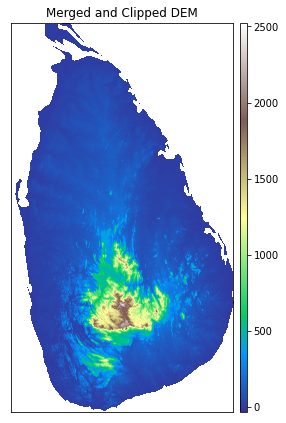

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,6)
plt.tight_layout()
plt.title('Merged and Clipped DEM')

ep.plot_bands(
    clipped,
    cmap="terrain",
    ax=ax
)
plt.show()

EarthPy Spatial also provides a [`hillshade()`](https://earthpy.readthedocs.io/en/latest/api/earthpy.spatial.html#earthpy.spatial.hillshade) function to compute hillshade from a DEM. Let's create a hillshade raster from the clipped dataset. 

The `hillshade` function expects a 2-dimentional array so we extract the `band1` and use it to create hillshade.

In [14]:
elevation = clipped.sel(band=1)
hillshade = es.hillshade(elevation, azimuth=300, altitude=40)

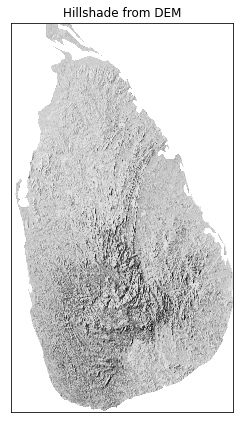

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,6)
plt.tight_layout()
plt.title('Hillshade from DEM')

ep.plot_bands(
    hillshade,
    cbar=False,
    ax=ax
)
plt.show()

Last step is to save the results to disk as GeoTiff files.

In [18]:
output_dem = 'clipped.tif'
output_dem_path = os.path.join(output_folder, output_dem)
clipped.rio.to_raster(output_dem_path, compress='LZW')

The hillshade created from EarthPy Spatial is just a numpy array. We need to create a georeferenced DataArray to save it to disk. We copy the coordinates and CRS from the clipped raster.

In [41]:
x_coords = clipped.x
y_coords = clipped.y
crs = clipped.rio.crs

Create a new dataarray.

In [42]:
hillshade_da = xr.DataArray(
    data=hillshade,
    coords={
        'y': y_coords,
        'x': x_coords
    }
)
hillshade_da.rio.write_crs(crs, inplace=True)
hillshade_da

<xarray.DataArray (y: 14061, x: 8045)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 9.829 9.829 9.829 9.829 ... 5.925 5.924 5.924 5.924
  * x            (x) float64 79.66 79.66 79.66 79.66 ... 81.89 81.89 81.89 81.89
    spatial_ref  int64 0

In [40]:
output_hillshade = 'hillshade.tif'
output_hillshade_path = os.path.join(output_folder, output_hillshade)
hillshade_da.rio.to_raster(output_hillshade_path, compress='LZW')